In [1]:
%load_ext autoreload
%autoreload 2

# Data

## Get Competition Data

In [1]:
!kaggle competitions files -c titanic

name                   size  creationDate         
---------------------  ----  -------------------  
gender_submission.csv   3KB  2018-04-09 05:33:22  
train.csv              60KB  2018-04-09 05:33:22  
test.csv               28KB  2018-04-09 05:33:22  


In [2]:
# download data
! kaggle competitions download -c titanic -p /notebooks/data/

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
# unzip
! unzip /notebooks/data/titanic.zip -d /notebooks/data/titanic

Archive:  /notebooks/data/titanic.zip
replace /notebooks/data/titanic/gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Data Watching

In [2]:
import numpy as np
import pandas as pd

In [3]:
trainDf = pd.read_csv('../data/titanic/train.csv')
testDf  = pd.read_csv('../data/titanic/test.csv')

In [4]:
trainDf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


|Variable|Definition|Key|
| ---- | ---- | ---- |
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

In [5]:
# Cabinの番号を抜く
## train
cabinTrain = trainDf.Cabin.str.extract('([A-Z])', expand=True)
cabinTrain.columns = ['Cabin']
## test
cabinTest = testDf.Cabin.str.extract('([A-Z])', expand=True)
cabinTest.columns = ['Cabin']

trainDf['Cabin'] = cabinTrain
testDf['Cabin']  = cabinTest

In [22]:
numColumns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
catColumns = ['Sex', 'Cabin', 'Embarked']

objectiveColumn = 'Survived'

## Preprocessing

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler

import sys
sys.path.append('..')
from src.utils import machineLearning

In [8]:
# preprocess numeric columns
numPreprocessPipeline = Pipeline([
    ('NumImputer',     Imputer(strategy='mean')),
    ('StandardScaler', StandardScaler())
])

trainNum = numPreprocessPipeline.fit_transform(trainDf[numColumns])
testNum  = numPreprocessPipeline.transform(testDf[numColumns])

trainNumDf = pd.DataFrame(trainNum, columns=numColumns)
testNumDf  = pd.DataFrame(testNum, columns=numColumns)

In [15]:
# preprocess categorical columns
catPreprocessPipeline = Pipeline([
    ('OneHotEncoder', machineLearning.CategoricalDataEncoder(catColumns, dropFirst=True))
])

trainCatDf = catPreprocessPipeline.fit_transform(trainDf[catColumns])
testCatDf  = catPreprocessPipeline.transform(testDf[catColumns])

../src/utils/machineLearning.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Dataset Split

In [46]:
from sklearn.model_selection import train_test_split

In [56]:
X = pd.concat([trainNumDf, trainCatDf], axis=1)
Y = trainDf[[objectiveColumn]]

testX = pd.concat([testNumDf, testCatDf], axis=1)

In [57]:
trainX, validX, trainY, validY = train_test_split(
    X,
    Y,
    test_size    = 0.2,
    random_state = 42,
    shuffle      = True,
)

# Modeling

In [76]:
import optuna.integration.lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix

In [62]:
train = lgb.Dataset(trainX, trainY)
valid = lgb.Dataset(validX, validY)

params = {
    'objective'   : 'binary',
    'metric'      : 'binary_logloss',
    'class_weight': 'balanced'
}
bestParams, history = {}, []

booster = lgb.train(
    params,
    train,
    valid_sets = valid,
    num_boost_round = 100,
    verbose_eval    = 0,
    best_params     = bestParams,
    tuning_history  = history,
)

/opt/conda/lib/python3.6/site-packages/optuna/_experimental.py:90: ExperimentalWarning:

train is experimental (supported from v0.18.0). The interface can change in the future.



  0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

feature_fraction, val_score: 0.459759:   0%|          | 0/7 [00:00<?, ?it/s][I 2020-05-27 01:24:40,168] Finished trial#0 with value: 0.45975902049693185 with parameters: {'feature_fraction': 0.8}. Best is trial#0 with value: 0.45975902049693185.


feature_fraction, val_score: 0.459759:  14%|#4        | 1/7 [00:00<00:00,  9.76it/s]

feature_fraction, val_score: 0.434816:  14%|#4        | 1/7 [00:00<00:00,  7.35it/s]

feature_fraction, val_score: 0.434816:  29%|##8       | 2/7 [00:00<00:00, 14.63it/s][I 2020-05-27 01:24:40,263] Finished trial#1 with value: 0.43481638710797954 with parameters: {'feature_fraction': 0.5}. Best is trial#1 with value: 0.43481638710797954.


feature_fraction, val_score: 0.4

num_leaves, val_score: 0.412217:  70%|#######   | 14/20 [00:01<00:00, 12.35it/s]

num_leaves, val_score: 0.412217:  70%|#######   | 14/20 [00:01<00:00, 12.35it/s][I 2020-05-27 01:24:42,005] Finished trial#21 with value: 0.4122174343377455 with parameters: {'num_leaves': 207}. Best is trial#7 with value: 0.4122174343377455.


num_leaves, val_score: 0.412217:  75%|#######5  | 15/20 [00:01<00:00, 12.35it/s]

num_leaves, val_score: 0.412217:  75%|#######5  | 15/20 [00:01<00:00, 12.35it/s]

num_leaves, val_score: 0.412217:  80%|########  | 16/20 [00:01<00:00, 12.04it/s][I 2020-05-27 01:24:42,093] Finished trial#22 with value: 0.4122174343377455 with parameters: {'num_leaves': 96}. Best is trial#7 with value: 0.4122174343377455.


num_leaves, val_score: 0.412217:  80%|########  | 16/20 [00:01<00:00, 12.04it/s]

num_leaves, val_score: 0.412217:  80%|########  | 16/20 [00:01<00:00, 12.04it/s][I 2020-05-27 01:24:42,191] Finished trial#23 with value: 0.4122174343377455 with parameters: {'num_lea

regularization_factors, val_score: 0.398023:   5%|5         | 1/20 [00:00<00:01, 12.27it/s]

regularization_factors, val_score: 0.398023:   5%|5         | 1/20 [00:00<00:01, 10.01it/s]

regularization_factors, val_score: 0.398023:  10%|#         | 2/20 [00:00<00:00, 19.90it/s][I 2020-05-27 01:24:43,676] Finished trial#41 with value: 0.39802329892660077 with parameters: {'lambda_l1': 3.887821987987392e-07, 'lambda_l2': 0.0001290088527059888}. Best is trial#41 with value: 0.39802329892660077.


regularization_factors, val_score: 0.398023:  10%|#         | 2/20 [00:00<00:00, 19.90it/s]

regularization_factors, val_score: 0.398023:  10%|#         | 2/20 [00:00<00:00, 19.90it/s][I 2020-05-27 01:24:43,751] Finished trial#42 with value: 0.4068883180422408 with parameters: {'lambda_l1': 0.29243221179247564, 'lambda_l2': 3.730463832044242e-05}. Best is trial#41 with value: 0.39802329892660077.


regularization_factors, val_score: 0.398023:  15%|#5        | 3/20 [00:00<00:00, 19.90it/s]

regular

regularization_factors, val_score: 0.395614:  95%|#########5| 19/20 [00:01<00:00, 13.06it/s]

regularization_factors, val_score: 0.395614:  95%|#########5| 19/20 [00:01<00:00, 13.06it/s]

regularization_factors, val_score: 0.395614: 100%|##########| 20/20 [00:01<00:00, 12.84it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.395614:   0%|          | 0/5 [00:00<?, ?it/s]

min_data_in_leaf, val_score: 0.393666:   0%|          | 0/5 [00:00<?, ?it/s][I 2020-05-27 01:24:45,185] Finished trial#60 with value: 0.39366641936900076 with parameters: {'min_child_samples': 10}. Best is trial#60 with value: 0.39366641936900076.


min_data_in_leaf, val_score: 0.393666:  20%|##        | 1/5 [00:00<00:00,  8.89it/s]

min_data_in_leaf, val_score: 0.393666:  20%|##        | 1/5 [00:00<00:00,  7.85it/s]

min_data_in_leaf, val_score: 0.393666:  40%|####      | 2/5 [00:00<00:00, 15.62it/s][I 2020-05-27 01:24:45,265] Finished trial#61 with value: 0.42422329299601597 with parameters:

In [81]:
pred = booster.predict(validX)
pred = [1 if p >= 0.5 else 0 for p in pred]
print('F1 Score: ', f1_score(validY, pred))
print('Confusion Matrix: ')
display(confusion_matrix(validY, pred))

F1 Score:  0.802721088435374
Confusion Matrix: 


array([[91, 14],
       [15, 59]])

# SHAP

In [82]:
import shap

In [83]:
explainer  = shap.TreeExplainer(booster, feature_perturbation = 'tree_path_dependent')
shapValues = explainer.shap_values(trainX)

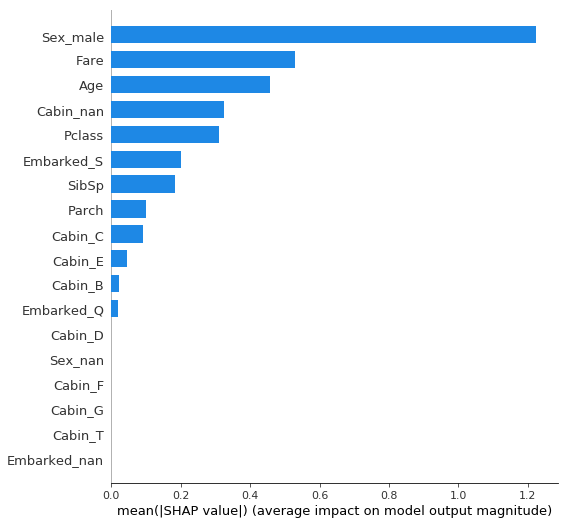

In [90]:
# 説明変数の寄与度
shap.summary_plot(
    shapValues,
    trainX,
    plot_type     = 'bar',
    feature_names = list(trainX.columns),
)

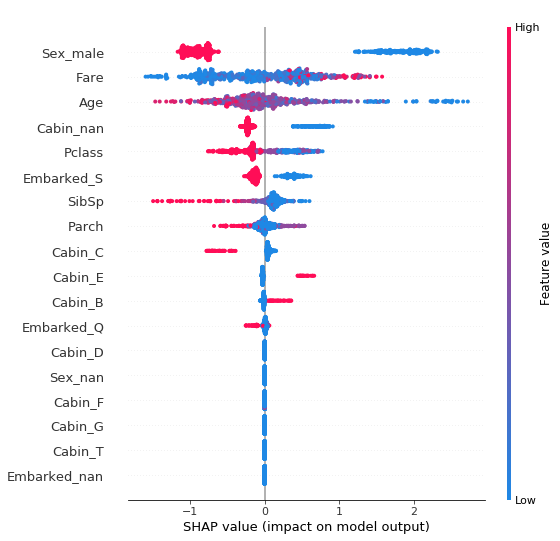

In [91]:
# 説明変数(y軸)と目的変数(x軸)の相関
shap.summary_plot(
    shapValues,
    trainX,
    plot_type     = 'dot',
    feature_names = list(trainX.columns),
)

# Submission

In [94]:
testPred = booster.predict(testX)
testPred = [1 if p >= 0.5 else 0 for p in testPred]

In [ ]:
submissionTemp = pd.read_csv('../data/titanic/gender_submission.csv')

submissionTemp['Survived'] = testPred

submissionTemp.to_csv('../data/titanic/submission.csv')

In [107]:
! kaggle competitions submit -c titanic -f ../data/titanic/submission.csv -m "Test submission"

100%|████████████████████████████████████████| 4.30k/4.30k [00:04<00:00, 902B/s]
Successfully submitted to Titanic: Machine Learning from Disaster